In [317]:
#@title Setup & Imports
import os
import zipfile
import pandas as pd
from src.MAE.MAE_dataset import MAEDataset
from src.MAE.MAE_model import MaskedAutoencoderCNN
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



from PIL import Image
import json
# import nltk
# from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import io
import random
from src.config import *
from src.dataset import load_csv_paths, create_dataloaders
from src.utils import build_vocab
from src.model import GRNN
from src.train import train_model, plot_history
from src.eval import test_loss, generate_question
from src.dataset import VQGTensorDataset
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [28]:
# import nltk
# import os

# nltk.download('punkt', download_dir='~/nltk_data')
# nltk.data.path.append(os.path.expanduser('~/nltk_data'))


In [287]:
import pandas as pd

def expand_questions(csv_path):
    df = pd.read_csv(csv_path)
    expanded_rows = []
    for _, row in df.iterrows():
        questions = str(row["questions"]).split('---')
        for q in questions:
            q = q.strip()
            if q:
                expanded_rows.append({
                    "image_id": row["image_id"],
                    "tensor_path": row["tensor_path"],
                    "questions": q  # single question per row
                })
    return pd.DataFrame(expanded_rows)


In [277]:
import os
import pandas as pd

# === CSV file paths ===
bing_csvs = [
    "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"
]

flickr_csvs = [
    "data/flickr_data/flickr_redistributed_indexes/flickr_train_tensor_index.csv",
    "data/flickr_data/flickr_redistributed_indexes/flickr_val_tensor_index.csv",
    "data/flickr_data/flickr_redistributed_indexes/flickr_test_tensor_index.csv"
]

# === Load, tag, and store all dataframes ===
dfs = []

for path in bing_csvs:
    df = pd.read_csv(path)
    df["source"] = "bing"
    dfs.append(df)

for path in flickr_csvs:
    df = pd.read_csv(path)
    df["source"] = "flickr"
    dfs.append(df)

# === Combine and clean ===
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df.dropna(subset=["tensor_path"]).reset_index(drop=True)
combined_df["tensor_path"] = combined_df["tensor_path"].apply(os.path.basename)

print(f"✅ Final combined dataset size: {len(combined_df)}")

# === Save to flat data/ directory ===
combined_path = "data/combined_tensor_index.csv"
combined_df.to_csv(combined_path, index=False)
print(f"📁 Saved to {combined_path}")


✅ Final combined dataset size: 3611
📁 Saved to data/combined_tensor_index.csv


In [ ]:
# combined_csv_path = "data/combined_tensor_index.csv"
# combined_df.to_csv(combined_csv_path, index=False)

In [ ]:
# Direct paths to CSVs
# train_csv = "data/flickr_data/flickr_redistributed_indexes/flickr_train_tensor_index.csv"
# val_csv   = "data/flickr_data/flickr_redistributed_indexes/flickr_val_tensor_index.csv"
# test_csv  = "data/flickr_data/flickr_redistributed_indexes/flickr_test_tensor_index.csv"



# train_df = expand_questions(train_csv)
# val_df = expand_questions(val_csv)
# test_df = expand_questions(test_csv)


# Read all questions from all splits
# questions = []
# for path in [train_csv, val_csv, test_csv]:
#     df = pd.read_csv(path)
#     questions.extend(df["questions"].dropna().tolist())


In [278]:
combined_csv = "data/combined_tensor_index.csv"
full_df = expand_questions(combined_csv)

In [ ]:
# train_df = expand_questions(train_csv)
# val_df = expand_questions(val_csv)
# test_df = expand_questions(test_csv)

In [ ]:
# train_exp_csv = "data/flickr_data/flickr_train_expanded.csv"
# val_exp_csv   = "data/flickr_data/flickr_val_expanded.csv"
# test_exp_csv  = "data/flickr_data/flickr_test_expanded.csv"

# train_df.to_csv(train_exp_csv, index=False)
# val_df.to_csv(val_exp_csv, index=False)
# test_df.to_csv(test_exp_csv, index=False)

In [ ]:
train_df, temp_df = train_test_split(
    full_df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Step 2: Split temp into val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half of 20% = 10%
    random_state=42,
    shuffle=True
)

# Confirm sizes
print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

# Optional: save to CSVs
train_df.to_csv("data/combined_train_tensor_index.csv", index=False)
val_df.to_csv("data/combined_val_tensor_index.csv", index=False)
test_df.to_csv("data/combined_test_tensor_index.csv", index=False)

Train: 14456
Val: 1807
Test: 1808


In [299]:
train_comb_csv = "data/combined_train_tensor_index.csv"
val_comb_csv   = "data/combined_val_tensor_index.csv"
test_comb_csv  = "data/combined_test_tensor_index.csv"

In [306]:
# dataset.py
from pathlib import Path
import torch
import pandas as pd
import re
from torch.utils.data import Dataset

# put this at module top
TENSOR_ROOT = Path("data") / "tensor_data"

class VQGTensorDataset(Dataset):
    def __init__(self, csv_path, vocab, max_length=20):
        self.df         = pd.read_csv(csv_path)
        self.vocab      = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row      = self.df.iloc[idx]
        filename = row["tensor_path"].strip()  # e.g. "bing_val_abc123.pt"

        # ALWAYS prefix with the tensor folder:
        tensor_path = TENSOR_ROOT / filename      # Path("data/tensor_data/bing_val_abc123.pt")

        if not tensor_path.exists():
            raise FileNotFoundError(f"Tensor not found at {tensor_path}")

        # torch.load accepts a Path, but if yours errors you can cast to str():
        image_tensor = torch.load(tensor_path).float()

        # … your existing question→indices logic …
        question = str(row["questions"]).split('---')[0].strip().lower()
        tokens = re.findall(r"\w+|[^\w\s]", question, re.UNICODE)

        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        indices = [self.vocab['<start>']] + indices + [self.vocab['<end>']]
        indices = indices[:self.max_length] + [self.vocab['<pad>']] * (self.max_length - len(indices))

        return image_tensor, torch.tensor(indices), question



In [307]:

questions = pd.concat([train_df, val_df, test_df])["questions"].dropna().tolist()
vocab, idx_to_word = build_vocab(questions)

# Datasets with base_dir for .pt files
# BASE_DIR = "data"
train_dataset = VQGTensorDataset(train_comb_csv, vocab, MAX_LENGTH)
val_dataset   = VQGTensorDataset(val_comb_csv, vocab, MAX_LENGTH)
test_dataset  = VQGTensorDataset(test_comb_csv, vocab, MAX_LENGTH)

# Dataloaders
from torch.utils.data import DataLoader
dataloaders = {
    "flickr": {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
        "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
        "test":  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False),
    }
}


In [318]:
model = GRNN(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)



Epoch 25: 100%|██████████| 226/226 [01:01<00:00,  3.70it/s]


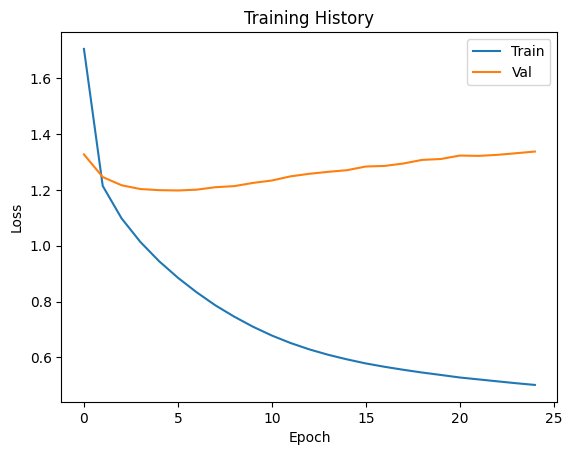

📉 Test Loss: 1.3147


In [319]:
history = train_model(model, dataloaders["flickr"]["train"], dataloaders["flickr"]["val"],
                      vocab, criterion, optimizer, device, 25)
plot_history(history)
test_loss(model, dataloaders["flickr"]["test"], vocab, criterion, device)


In [ ]:
import torch.nn as nn
import torch
import torchvision.models as models

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.gru(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.lstm(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear = nn.Sequential(
            nn.Linear(embed_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out = self.transformer(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class GRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class LSTMModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        # resnet.load_state_dict(torch.load("pretrained_encoder.pth"))
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class TransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)


In [334]:
# from src.model import LSTMModel  # assuming you've imported from your updated model.py

lstm_model = LSTMModel(EMBED_SIZE, HIDDEN_SIZE, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR, weight_decay=1e-5)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.5.weight", "encoder.5.bias". 

In [ ]:
history_lstm = train_model(lstm_model, dataloaders["flickr"]["train"], dataloaders["flickr"]["val"], vocab, criterion, optimizer, device, EPOCHS)
plot_history(*history_lstm, label="LSTM")
test_loss(lstm_model, dataloaders["flickr"]["test"], vocab, criterion, device)


In [ ]:
generate_question(lstm_model, dataloaders["flickr"]["test"], vocab, idx_to_word, device=device)

In [326]:
def generate_question(model, test_loader, vocab, idx_to_word, device):
    model.eval()
    images, _, texts = next(iter(test_loader))
    image = images[0].unsqueeze(0).to(device)
    original_question = texts[0]

    with torch.no_grad():
        feat = model.encoder(image)
        inp = torch.tensor([[vocab["<start>"]]], device=device)
        output = []
        for _ in range(20):
            out = model.decoder(feat, inp)
            pred = out[0, -1].argmax().item()
            if pred == vocab["<end>"]:
                break
            output.append(pred)
            inp = torch.cat([inp, torch.tensor([[pred]], device=device)], dim=1)

    decoded = " ".join(idx_to_word.get(i, "<unk>") for i in output)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Generated: {decoded}\nOriginal: {original_question}")
    plt.show()

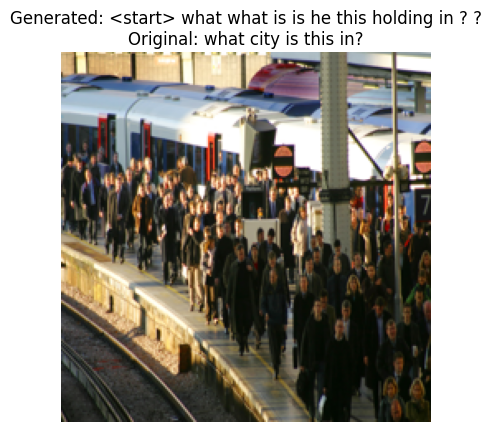

In [327]:
generate_question(model, dataloaders["flickr"]["test"], vocab, idx_to_word, device)

In [ ]:
#next steps: 1) Data Agument (labels) dataset -> retrain 2) SSL + Pretrain for Image and maybe decoder\


In [125]:
csvs = [
    "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"
]


all_paths = []
for csv in csvs:
    df = pd.read_csv(csv)
    all_paths += [os.path.join("data/bing_data", p) for p in df["tensor_path"].dropna().tolist()]

print(f"✅ Loaded {len(all_paths)} image paths")


✅ Loaded 1922 image paths


In [ ]:
# mae_train.py
import torch
from torch.utils.data import DataLoader
from src.MAE.MAE_dataset import MAEDataset
from src.MAE.MAE_model import MaskedAutoencoderCNN
import os
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- CONFIG ---
EPOCHS = 15
BATCH_SIZE = 64
PATCH_SIZE = 16
MASK_RATIO = 0.5  # Reduced from 0.75
EMBED_DIM = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load paths using unified formatting
csvs = [
    "data/bing_data/bing_redistributed_indexes/bing_train_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_val_tensor_index.csv",
    "data/bing_data/bing_redistributed_indexes/bing_test_tensor_index.csv"
]

all_paths = []
for csv in csvs:
    df = pd.read_csv(csv)
    all_paths += [os.path.join("data/bing_data", p) for p in df["tensor_path"].dropna().tolist()]

print(f"✅ Loaded {len(all_paths)} image paths")

# Split train and val paths
train_paths = all_paths[:int(0.8 * len(all_paths))]
val_paths = all_paths[int(0.8 * len(all_paths)) :]

# Create datasets and dataloaders
train_dataset = MAEDataset(train_paths, patch_size=PATCH_SIZE, mask_ratio=MASK_RATIO)
val_dataset = MAEDataset(val_paths, patch_size=PATCH_SIZE, mask_ratio=MASK_RATIO)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = MaskedAutoencoderCNN(embed_dim=EMBED_DIM, patch_size=PATCH_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
train_history = []
val_history = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for masked, target, mask in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{EPOCHS}"):
        masked, target, mask = masked.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
        output = model(masked, mask)
        loss = F.mse_loss(output[mask], target[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_history.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for masked, target, mask in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{EPOCHS}"):
            masked, target, mask = masked.to(DEVICE), target.to(DEVICE), mask.to(DEVICE)
            output = model(masked, mask)
            loss = F.mse_loss(output[mask], target[mask])
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_history.append(avg_val_loss)

    print(f"📉 Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

# Save encoder weights
torch.save(model.encoder.state_dict(), "pretrained_encoder.pth")
print("✅ Saved encoder weights to pretrained_encoder.pth")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_history, label="Train Loss", marker='o')
plt.plot(val_history, label="Val Loss", marker='s')
plt.title("MAE Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (masked patches)")
plt.grid(True)
plt.legend()
plt.show()


In [134]:
import random

def show_mae_reconstruction(model, dataset, idx=None):
    model.eval()
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    masked, target, mask = dataset[idx]
    masked = masked.unsqueeze(0).to(DEVICE)
    mask = mask.unsqueeze(0).to(DEVICE)
    target = target.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(masked, mask)

    recon_img = out[0]
    true_img = target[0]
    masked_img = masked[0]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    def reconstruct_image(patches):
        grid = torch.zeros(3, 224, 224)
        n = 0
        for i in range(0, 224, PATCH_SIZE):
            for j in range(0, 224, PATCH_SIZE):
                grid[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = patches[n]
                n += 1
        return grid.clamp(0, 1)

    axs[0].imshow(reconstruct_image(true_img).permute(1, 2, 0).cpu())
    axs[0].set_title("Original Image")

    axs[1].imshow(reconstruct_image(masked_img).permute(1, 2, 0).cpu())
    axs[1].set_title("Masked Input")

    axs[2].imshow(reconstruct_image(recon_img).permute(1, 2, 0).cpu())
    axs[2].set_title("Reconstruction")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


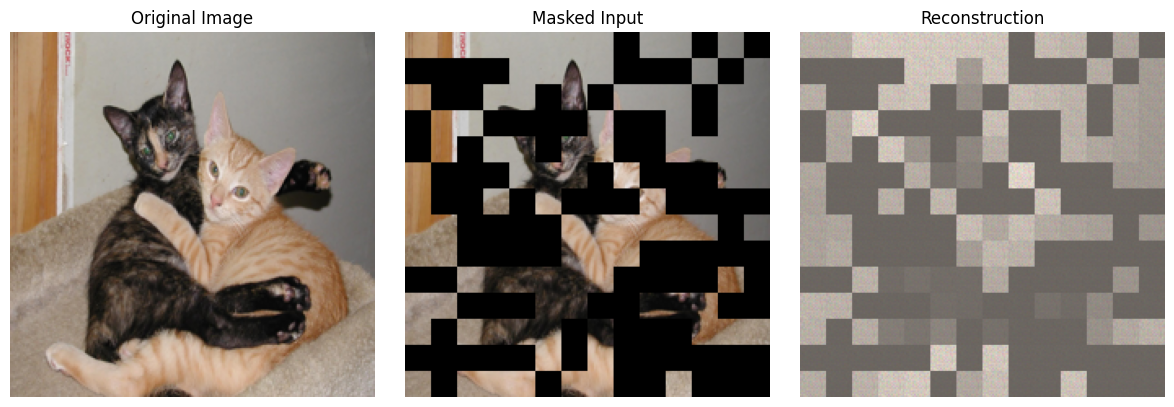

In [135]:
# Example usage
show_mae_reconstruction(model, val_dataset)